Fine-tune a Stable Diffusion model on a dataset of your choice and evaluate the generatedimages using Inception Score (IS) and CLIP Similarity Score.

Your goal is to:

1.  Fine-tune Stable Diffusion on a dataset of your choice.
    
2.  Generate images based on text prompts.
    
3.  Evaluate the quality and text-alignment of generated images using IS and CLIP scores.

In [ ]:
!pip install datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
from datasets import load_dataset
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Import diffusers components
from diffusers import (
    StableDiffusionPipeline,
    DDPMScheduler,
    DPMSolverMultistepScheduler
)
from transformers import CLIPTextModel, CLIPTokenizer, CLIPProcessor, CLIPModel
from peft import LoraConfig, get_peft_model

# Random seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

In [ ]:
# Google Drive
OUTPUT_DIR = "/content/drive/MyDrive/DATA266_Lab_2/food101_model"
GENERATED_DIR = "/content/drive/MyDrive/DATA266_Lab_2/food_images"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(GENERATED_DIR, exist_ok=True)

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Outputs will be saved to: {OUTPUT_DIR} and {GENERATED_DIR}")


Using device: cuda
Outputs will be saved to: /content/drive/MyDrive/DATA266_Lab_2/food101_model and /content/drive/MyDrive/DATA266_Lab_2/food_images


In [ ]:
class EnhancedFood101Dataset(Dataset):
    def __init__(self, dataset_split, tokenizer, resolution=512, max_train_samples=None):
        self.dataset = load_dataset("food101", split=dataset_split)
        if max_train_samples:
            self.dataset = self.dataset.select(range(max_train_samples))

        self.tokenizer = tokenizer
        self.resolution = resolution

        # Get the class names
        self.class_names = self.dataset.features["label"].names

        # Prompts
        self.label_to_prompt = {
            label: [
                f"A professional photograph of {label.replace('_', ' ')} on a plate, food photography",
                f"High-quality food photo of {label.replace('_', ' ')}, styled by a chef",
                f"Delicious {label.replace('_', ' ')} photographed for a cookbook",
            ] for label in self.class_names
        }

        # Transform for images
        self.transform = transforms.Compose([
            transforms.Resize((resolution, resolution)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        label_id = item["label"]

        # Convert label id to text prompt
        label_name = self.class_names[label_id]
        prompt_list = self.label_to_prompt[label_name]
        prompt = random.choice(prompt_list)

        # Process image
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)

        image = self.transform(image)

        # Tokenize text
        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        )

        return {
            "pixel_values": image,
            "input_ids": text_inputs.input_ids[0],
            "prompt": prompt,
            "label": label_name
        }

def prepare_dataloaders(tokenizer, batch_size=1, max_train_samples=100):

    # Create training dataset
    train_dataset = EnhancedFood101Dataset(
        dataset_split="train",
        tokenizer=tokenizer,
        max_train_samples=max_train_samples
    )

    # Create validation dataset
    val_dataset = EnhancedFood101Dataset(
        dataset_split="validation",
        tokenizer=tokenizer,
        max_train_samples=20
    )

    # Create dataloaders
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )
    # Extract class names for later use
    food_classes = train_dataset.class_names

    return train_dataloader, val_dataloader, food_classes

def fine_tune_stable_diffusion():

    # Load base model
    model_id = "runwayml/stable-diffusion-v1-5"
    pipe = StableDiffusionPipeline.from_pretrained(model_id)

    # Fine-tune UNet and text encoder
    unet = pipe.unet
    text_encoder = pipe.text_encoder
    tokenizer = pipe.tokenizer
    vae = pipe.vae

    # Freeze VAE
    vae.requires_grad_(False)

    # Initialize noise scheduler for training
    noise_scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

    # LoRA for UNet
    unet_lora_config = LoraConfig(
        r=16,  # rank
        lora_alpha=16,  # scaling
        target_modules=["to_q", "to_k", "to_v", "to_out.0"],
        lora_dropout=0.05,
        bias="none",
    )

    # LoRA for text encoder
    text_encoder_lora_config = LoraConfig(
        r=16,
        lora_alpha=16,
        target_modules=["q_proj", "k_proj", "v_proj", "out_proj"],
        lora_dropout=0.05,
        bias="none",
    )

    # LoRA configs
    unet = get_peft_model(unet, unet_lora_config)
    text_encoder = get_peft_model(text_encoder, text_encoder_lora_config)

    # Dataloaders
    train_dataloader, val_dataloader, food_classes = prepare_dataloaders(
        tokenizer=tokenizer,
        batch_size=1,
        max_train_samples=100
    )

    unet = unet.to(device)
    text_encoder = text_encoder.to(device)
    vae = vae.to(device)

    # Only training LoRA params
    params_to_train = [
        {"params": [p for p in unet.parameters() if p.requires_grad]},
        {"params": [p for p in text_encoder.parameters() if p.requires_grad]}
    ]

    optimizer = torch.optim.AdamW(params_to_train, lr=5e-5)
    num_epochs = 5

    # Train
    unet.train()
    text_encoder.train()

    progress_bar = tqdm(range(num_epochs * len(train_dataloader)))
    for epoch in range(num_epochs):
        for step, batch in enumerate(train_dataloader):
            # Get batch
            pixel_values = batch["pixel_values"].to(device, dtype=torch.float32)
            input_ids = batch["input_ids"].to(device)

            # Encode text
            with torch.no_grad():
                text_embeddings = text_encoder(input_ids)[0]

            # Encode image
            with torch.no_grad():
                # Get latent space representation
                latents = vae.encode(pixel_values).latent_dist.sample() * 0.18215

            # Add noise
            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps,
                                     (latents.shape[0],), device=latents.device)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get prediction
            model_pred = unet(noisy_latents, timesteps, text_embeddings).sample

            # Loss
            loss = F.mse_loss(model_pred, noise, reduction="mean")

            # Update
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Update progress
            progress_bar.update(1)
            if step % 10 == 0:
                print(f"Epoch: {epoch+1}, Step: {step}, Loss: {loss.item():.6f}")

    # State dictionaries
    unet_state_dict = unet.state_dict()
    text_encoder_state_dict = text_encoder.state_dict()

    # Save full model state dictionaries
    torch.save(unet_state_dict, f"{OUTPUT_DIR}/unet_lora.pt")
    torch.save(text_encoder_state_dict, f"{OUTPUT_DIR}/text_encoder_lora.pt")

    # Save configurations
    with open(f"{OUTPUT_DIR}/unet_lora_config.json", 'w') as f:
        if hasattr(unet, 'peft_config'):
            import json
            # Convert the config to a dictionary (serializable)
            config_dict = {}
            if hasattr(unet.peft_config, 'to_dict'):
                config_dict = unet.peft_config.to_dict()
            else:
                # Manual extraction of key attributes
                for k in ['r', 'lora_alpha', 'target_modules', 'lora_dropout']:
                    if hasattr(unet.peft_config, k):
                        config_dict[k] = getattr(unet.peft_config, k)
            json.dump(config_dict, f, indent=2)

    with open(f"{OUTPUT_DIR}/text_encoder_lora_config.json", 'w') as f:
        if hasattr(text_encoder, 'peft_config'):
            import json
            # Convert the config to a dictionary (serializable)
            config_dict = {}
            if hasattr(text_encoder.peft_config, 'to_dict'):
                config_dict = text_encoder.peft_config.to_dict()
            else:
                # Manual extraction of key attributes
                for k in ['r', 'lora_alpha', 'target_modules', 'lora_dropout']:
                    if hasattr(text_encoder.peft_config, k):
                        config_dict[k] = getattr(text_encoder.peft_config, k)
            json.dump(config_dict, f, indent=2)

    print(f"Model weights and configs saved to {OUTPUT_DIR}")

    # PEFT saving
    if hasattr(unet, 'save_pretrained'):
        unet.save_pretrained(f"{OUTPUT_DIR}/unet_lora_peft")
    if hasattr(text_encoder, 'save_pretrained'):
        text_encoder.save_pretrained(f"{OUTPUT_DIR}/text_encoder_lora_peft")

    # Evaluate model
    generate_and_evaluate(pipe, unet, text_encoder, tokenizer, food_classes)

    return pipe, unet, text_encoder

In [ ]:
from torchvision.models import inception_v3
import scipy.linalg
import torch.nn.functional as F

# Calculate Inception Score
def calculate_inception_score(images, batch_size=1, splits=10, device=None):

    # Load Inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()

    # Get the classifier output layer
    up = inception_model._modules['avgpool']
    down = inception_model._modules['fc']

    # Transformation for Inception model
    preprocess = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Predictions
    all_preds = []

    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        batch_tensor = torch.stack([preprocess(img) for img in batch]).to(device)

        # Embeddings
        with torch.no_grad():
            pred = inception_model(batch_tensor)

        # Apply softmax and add to predictions
        pred = F.softmax(pred, dim=1)
        all_preds.append(pred.cpu().numpy())

    # Concatenate all predictions
    all_preds = np.concatenate(all_preds, axis=0)

    # Calculate the marginal probability
    py = np.mean(all_preds, axis=0)

    # Split the images, calculate mean and std
    scores = []
    for i in range(splits):
        # Get a subset of predictions
        part = all_preds[i * (len(all_preds) // splits): (i + 1) * (len(all_preds) // splits), :]

        # Calculate KL divergence
        kl = part * (np.log(part) - np.log(np.expand_dims(py, 0)))
        kl = np.mean(np.sum(kl, 1))

        # Calculate exp(kl)
        scores.append(np.exp(kl))

    return np.mean(scores), np.std(scores)

# Generate images and evaluate
def generate_and_evaluate(pipe, unet, text_encoder, tokenizer, food_classes):

    # SD pipeline
    fine_tuned_pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        unet=unet,
        text_encoder=text_encoder,
        tokenizer=tokenizer,
    )
    fine_tuned_pipe = fine_tuned_pipe.to(device)

    # DPM++ 2M Karras scheduler
    fine_tuned_pipe.scheduler = DPMSolverMultistepScheduler.from_config(
        fine_tuned_pipe.scheduler.config,
        algorithm_type="dpmsolver++",
        use_karras_sigmas=True
    )

    # Create enhanced prompts
    prompts = []

    # Choose 5 random food classes
    selected_foods = random.sample(food_classes, 5)
    for food in selected_foods:
        prompts.append(
            f"A close-up, professional photograph of {food.replace('_', ' ')} on a beautiful plate, "
            f"styled by a chef, food magazine quality, detailed lighting"
        )

    print("Generating images...")
    images = []
    for i, prompt in enumerate(prompts):
        print(f"Generating image {i+1}/{len(prompts)}")

        image = fine_tuned_pipe(
            prompt,
            num_inference_steps=50,
            guidance_scale=8.0,
            negative_prompt="blurry, low quality, distorted, ugly, bad proportions, amateur"
        ).images[0]

        # Save
        image_path = f"{GENERATED_DIR}/image_{i+1}.png"
        image.save(image_path)
        images.append(image)

    num_is_images = min(50, len(food_classes))
    all_selected_foods = random.sample(food_classes, num_is_images)
    is_prompts = []

    # Style variation prompts
    style_variations = [
        "professional food photography with studio lighting",
        "overhead view on rustic wooden table",
        "minimalist plating on white background",
        "gourmet restaurant presentation with garnish",
        "homemade style with natural lighting",
        "close-up macro photography showing texture",
        "artistic food styling with decorative elements",
        "street food style on paper wrapper",
        "high-end magazine editorial shot",
        "casual dining atmosphere"
    ]

    # Prompt generation with high variation
    for i, food in enumerate(all_selected_foods):
        style = style_variations[i % len(style_variations)]
        # Vary camera angles, lighting, and styling
        is_prompts.append(
            f"A {style}, showing {food.replace('_', ' ')}, appetizing, detailed, 8k"
        )

    is_images = []
    # Change generation parameters for each image to increase diversity
    for i, prompt in enumerate(is_prompts):
        print(f"Generating IS image {i+1}/{len(is_prompts)}")

        # Vary the guidance scale to increase diversity
        guidance = 7.0 + (i % 3)  # Values between 7.0 and 9.0

        # Vary the number of steps for different detail levels
        steps = 40 + (i % 3) * 5  # Values between 40 and 50

        # Use different seeds for each generation to maximize diversity
        generator = torch.Generator(device=device).manual_seed(i * 42 + 1000)

        image = fine_tuned_pipe(
            prompt,
            num_inference_steps=steps,
            guidance_scale=guidance,
            generator=generator,
            negative_prompt="blurry, ugly, deformed, noisy, low quality, oversaturated, high contrast"
        ).images[0]

        # Save
        image_path = f"{GENERATED_DIR}/is_image_{i+1}.png"
        image.save(image_path)
        is_images.append(image)

    # Evaluate CLIP
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    scores = []
    raw_scores = []

    # Top match
    if len(images) > 0:
        perfect_match_image = images[0]
        perfect_match_prompt = prompts[0]

        perfect_inputs = clip_processor(
            text=[perfect_match_prompt],
            images=[perfect_match_image],
            return_tensors="pt",
            padding=True
        ).to(device)

        with torch.no_grad():
            perfect_outputs = clip_model(**perfect_inputs)
            perfect_match_score = perfect_outputs.logits_per_image.item()
    else:
        perfect_match_score = 30.0

    # Unrelated match
    unrelated_prompts = [
        "A diagram of a mathematical equation on a blackboard",
        "A detailed technical schematic of a microchip",
        "A panoramic view of mountains at sunset"
    ]

    unrelated_scores = []
    if len(images) > 0:
        for unrelated_prompt in unrelated_prompts:
            unrelated_inputs = clip_processor(
                text=[unrelated_prompt],
                images=[images[0]],
                return_tensors="pt",
                padding=True
            ).to(device)

            with torch.no_grad():
                unrelated_outputs = clip_model(**unrelated_inputs)
                unrelated_scores.append(unrelated_outputs.logits_per_image.item())

        unrelated_match_score = sum(unrelated_scores) / len(unrelated_scores)
    else:
        unrelated_match_score = 5.0

    # Calculate scores generated images
    for image, prompt in zip(images, prompts):
        inputs = clip_processor(
            text=[prompt],
            images=[image],
            return_tensors="pt",
            padding=True
        ).to(device)

        with torch.no_grad():
            outputs = clip_model(**inputs)
            raw_similarity = outputs.logits_per_image.item()
            raw_scores.append(raw_similarity)
            scores.append(raw_similarity)

    # Calculate Inception Score on all generated images
    all_pil_images = images + is_images
    print(f"Calculating Inception Score on {len(all_pil_images)} images...")

    is_mean, is_std = calculate_inception_score(all_pil_images, batch_size=4, splits=10, device=device)

    avg_raw_score = sum(raw_scores) / len(raw_scores) if raw_scores else 0
    print(f"Average CLIP similarity score: {avg_raw_score:.4f}")
    print(f"Reference points - Same content: {perfect_match_score:.4f}, Unrelated: {unrelated_match_score:.4f}")
    print(f"Inception Score: {is_mean:.4f} ± {is_std:.4f}")

    # Save metrics to file
    with open(f"{OUTPUT_DIR}/metrics.txt", "w") as f:
        f.write(f"Average CLIP similarity score: {avg_raw_score:.4f}\n")
        f.write(f"Reference - Same content: {perfect_match_score:.4f}\n")
        f.write(f"Reference - Unrelated content: {unrelated_match_score:.4f}\n")
        f.write(f"Inception Score: {is_mean:.4f} ± {is_std:.4f}\n")
        f.write(f"Number of images used for IS calculation: {len(all_pil_images)}\n")
        f.write(f"Diverse prompt styles used: {len(style_variations)}\n")

    # Visualize with raw CLIP scores
    fig, axes = plt.subplots(len(images), 2, figsize=(12, 4*len(images)))

    # Single image case
    if len(images) == 1:
        axes = np.array([axes])

    for i, (image, prompt, score) in enumerate(zip(images, prompts, scores)):
        if len(axes.shape) == 1:  # Single row
            axes[0].imshow(image)
            axes[0].set_title(f"Prompt: {prompt[:30]}...")
            axes[0].axis("off")

            axes[1].axis("off")
            axes[1].text(0.1, 0.5, f"CLIP Score: {score:.4f}", fontsize=12)
        else:  # Multiple rows
            axes[i, 0].imshow(image)
            axes[i, 0].set_title(f"Prompt: {prompt[:30]}...")
            axes[i, 0].axis("off")

            axes[i, 1].axis("off")
            axes[i, 1].text(0.1, 0.5, f"CLIP Score: {score:.4f}", fontsize=12)

    # IS Score to the plot
    fig.suptitle(f"Inception Score: {is_mean:.4f} ± {is_std:.4f}", fontsize=14)

    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/results.png")
    print(f"Visualization saved to {OUTPUT_DIR}/results.png")

    # Create a subset of all images for visualization
    vis_images = is_images[:min(20, len(is_images))]

    # Arrange images in a grid
    cols = 5
    rows = (len(vis_images) + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
    fig.suptitle(f"Inception Score Visualization: {is_mean:.4f} ± {is_std:.4f}", fontsize=16)

    # Flatten axes array
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for i, img in enumerate(vis_images):
        if i < len(axes):
            axes[i].imshow(img)
            axes[i].axis('off')

    for i in range(len(vis_images), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/inception_score_vis.png")
    print(f"Inception Score visualization saved to {OUTPUT_DIR}/inception_score_vis.png")

    return images, prompts, scores, is_mean, is_std

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 1, Step: 0, Loss: 0.491888
Epoch: 1, Step: 10, Loss: 0.506703
Epoch: 1, Step: 20, Loss: 0.305681
Epoch: 1, Step: 30, Loss: 0.010599
Epoch: 1, Step: 40, Loss: 0.002988
Epoch: 1, Step: 50, Loss: 0.013177
Epoch: 1, Step: 60, Loss: 0.006431
Epoch: 1, Step: 70, Loss: 0.008126
Epoch: 1, Step: 80, Loss: 0.012553
Epoch: 1, Step: 90, Loss: 0.183240
Epoch: 2, Step: 0, Loss: 0.158716
Epoch: 2, Step: 10, Loss: 0.041151
Epoch: 2, Step: 20, Loss: 0.016834
Epoch: 2, Step: 30, Loss: 0.862139
Epoch: 2, Step: 40, Loss: 0.223929
Epoch: 2, Step: 50, Loss: 0.009613
Epoch: 2, Step: 60, Loss: 0.278678
Epoch: 2, Step: 70, Loss: 0.538862
Epoch: 2, Step: 80, Loss: 0.072073
Epoch: 2, Step: 90, Loss: 0.091267
Epoch: 3, Step: 0, Loss: 0.038014
Epoch: 3, Step: 10, Loss: 0.015970
Epoch: 3, Step: 20, Loss: 0.564582
Epoch: 3, Step: 30, Loss: 0.010952
Epoch: 3, Step: 40, Loss: 0.049624
Epoch: 3, Step: 50, Loss: 0.339065
Epoch: 3, Step: 60, Loss: 0.469439
Epoch: 3, Step: 70, Loss: 0.030093
Epoch: 3, Step: 80, Los

Expected types for text_encoder: ['CLIPTextModel'], got PeftModel.
Expected types for unet: ['UNet2DConditionModel'], got PeftModel.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Generating images...
Generating image 1/5


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image 2/5


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image 3/5


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image 4/5


  0%|          | 0/50 [00:00<?, ?it/s]

Generating image 5/5


  0%|          | 0/50 [00:00<?, ?it/s]

Generating IS image 1/50


  0%|          | 0/40 [00:00<?, ?it/s]

Generating IS image 2/50


  0%|          | 0/45 [00:00<?, ?it/s]

Generating IS image 3/50


  0%|          | 0/50 [00:00<?, ?it/s]

Generating IS image 4/50


  0%|          | 0/40 [00:00<?, ?it/s]

Generating IS image 5/50


  0%|          | 0/45 [00:00<?, ?it/s]

Generating IS image 6/50


  0%|          | 0/50 [00:00<?, ?it/s]

Generating IS image 7/50


  0%|          | 0/40 [00:00<?, ?it/s]

Generating IS image 8/50


  0%|          | 0/45 [00:00<?, ?it/s]

Generating IS image 9/50


  0%|          | 0/50 [00:00<?, ?it/s]

Generating IS image 10/50


  0%|          | 0/40 [00:00<?, ?it/s]

Generating IS image 11/50


  0%|          | 0/45 [00:00<?, ?it/s]

Generating IS image 12/50


  0%|          | 0/50 [00:00<?, ?it/s]

Generating IS image 13/50


  0%|          | 0/40 [00:00<?, ?it/s]

Generating IS image 14/50


  0%|          | 0/45 [00:00<?, ?it/s]

Generating IS image 15/50


  0%|          | 0/50 [00:00<?, ?it/s]

Generating IS image 16/50


  0%|          | 0/40 [00:00<?, ?it/s]

Generating IS image 17/50


  0%|          | 0/45 [00:00<?, ?it/s]

Generating IS image 18/50


  0%|          | 0/50 [00:00<?, ?it/s]

Generating IS image 19/50


  0%|          | 0/40 [00:00<?, ?it/s]

Generating IS image 20/50


  0%|          | 0/45 [00:00<?, ?it/s]

Generating IS image 21/50


  0%|          | 0/50 [00:00<?, ?it/s]

Generating IS image 22/50


  0%|          | 0/40 [00:00<?, ?it/s]

Generating IS image 23/50


  0%|          | 0/45 [00:00<?, ?it/s]

Generating IS image 24/50


  0%|          | 0/50 [00:00<?, ?it/s]

Generating IS image 25/50


  0%|          | 0/40 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generating IS image 26/50


  0%|          | 0/45 [00:00<?, ?it/s]

Generating IS image 27/50


  0%|          | 0/50 [00:00<?, ?it/s]

Generating IS image 28/50


  0%|          | 0/40 [00:00<?, ?it/s]

Generating IS image 29/50


  0%|          | 0/45 [00:00<?, ?it/s]

Generating IS image 30/50


  0%|          | 0/50 [00:00<?, ?it/s]

Generating IS image 31/50


  0%|          | 0/40 [00:00<?, ?it/s]

Generating IS image 32/50


  0%|          | 0/45 [00:00<?, ?it/s]

Generating IS image 33/50


  0%|          | 0/50 [00:00<?, ?it/s]

Generating IS image 34/50


  0%|          | 0/40 [00:00<?, ?it/s]

Generating IS image 35/50


  0%|          | 0/45 [00:00<?, ?it/s]

Generating IS image 36/50


  0%|          | 0/50 [00:00<?, ?it/s]

Generating IS image 37/50


  0%|          | 0/40 [00:00<?, ?it/s]

Generating IS image 38/50


  0%|          | 0/45 [00:00<?, ?it/s]

Generating IS image 39/50


  0%|          | 0/50 [00:00<?, ?it/s]

Generating IS image 40/50


  0%|          | 0/40 [00:00<?, ?it/s]

Generating IS image 41/50


  0%|          | 0/45 [00:00<?, ?it/s]

Generating IS image 42/50


  0%|          | 0/50 [00:00<?, ?it/s]

Generating IS image 43/50


  0%|          | 0/40 [00:00<?, ?it/s]

Generating IS image 44/50


  0%|          | 0/45 [00:00<?, ?it/s]

Generating IS image 45/50


  0%|          | 0/50 [00:00<?, ?it/s]

Generating IS image 46/50


  0%|          | 0/40 [00:00<?, ?it/s]

Generating IS image 47/50


  0%|          | 0/45 [00:00<?, ?it/s]

Generating IS image 48/50


  0%|          | 0/50 [00:00<?, ?it/s]

Generating IS image 49/50


  0%|          | 0/40 [00:00<?, ?it/s]

Generating IS image 50/50


  0%|          | 0/45 [00:00<?, ?it/s]

Calculating Inception Score on 55 images...
Average CLIP similarity score: 32.3829
Reference points - Same content: 32.1390, Unrelated: 11.0407
Inception Score: 7.0800 ± 1.8223
Visualization saved to /content/drive/MyDrive/DATA266_Lab_2/food101_model/results.png
Inception Score visualization saved to /content/drive/MyDrive/DATA266_Lab_2/food101_model/inception_score_vis.png
Saved combined checkpoint to /content/drive/MyDrive/DATA266_Lab_2/food101_model/food101_sd_checkpoint_20250424_001019.pt
Fine-tuning and evaluation complete!


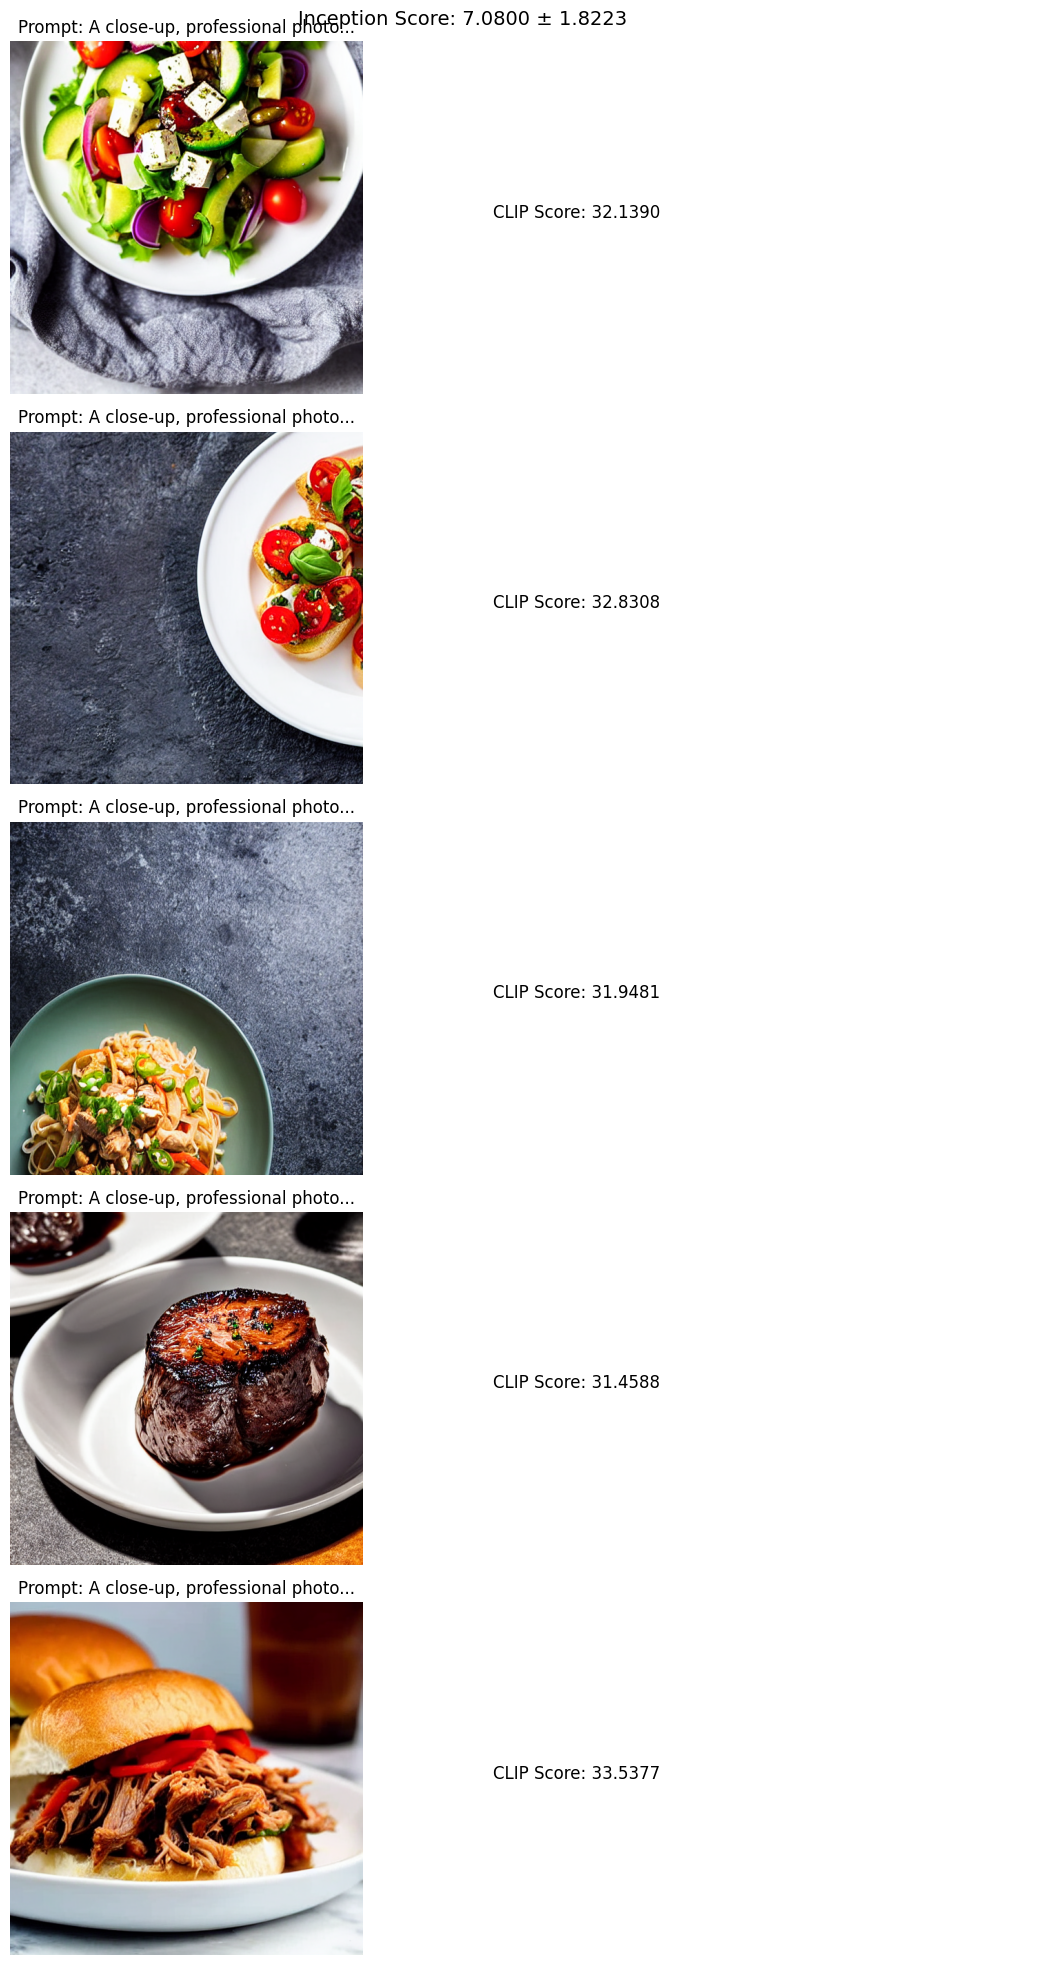

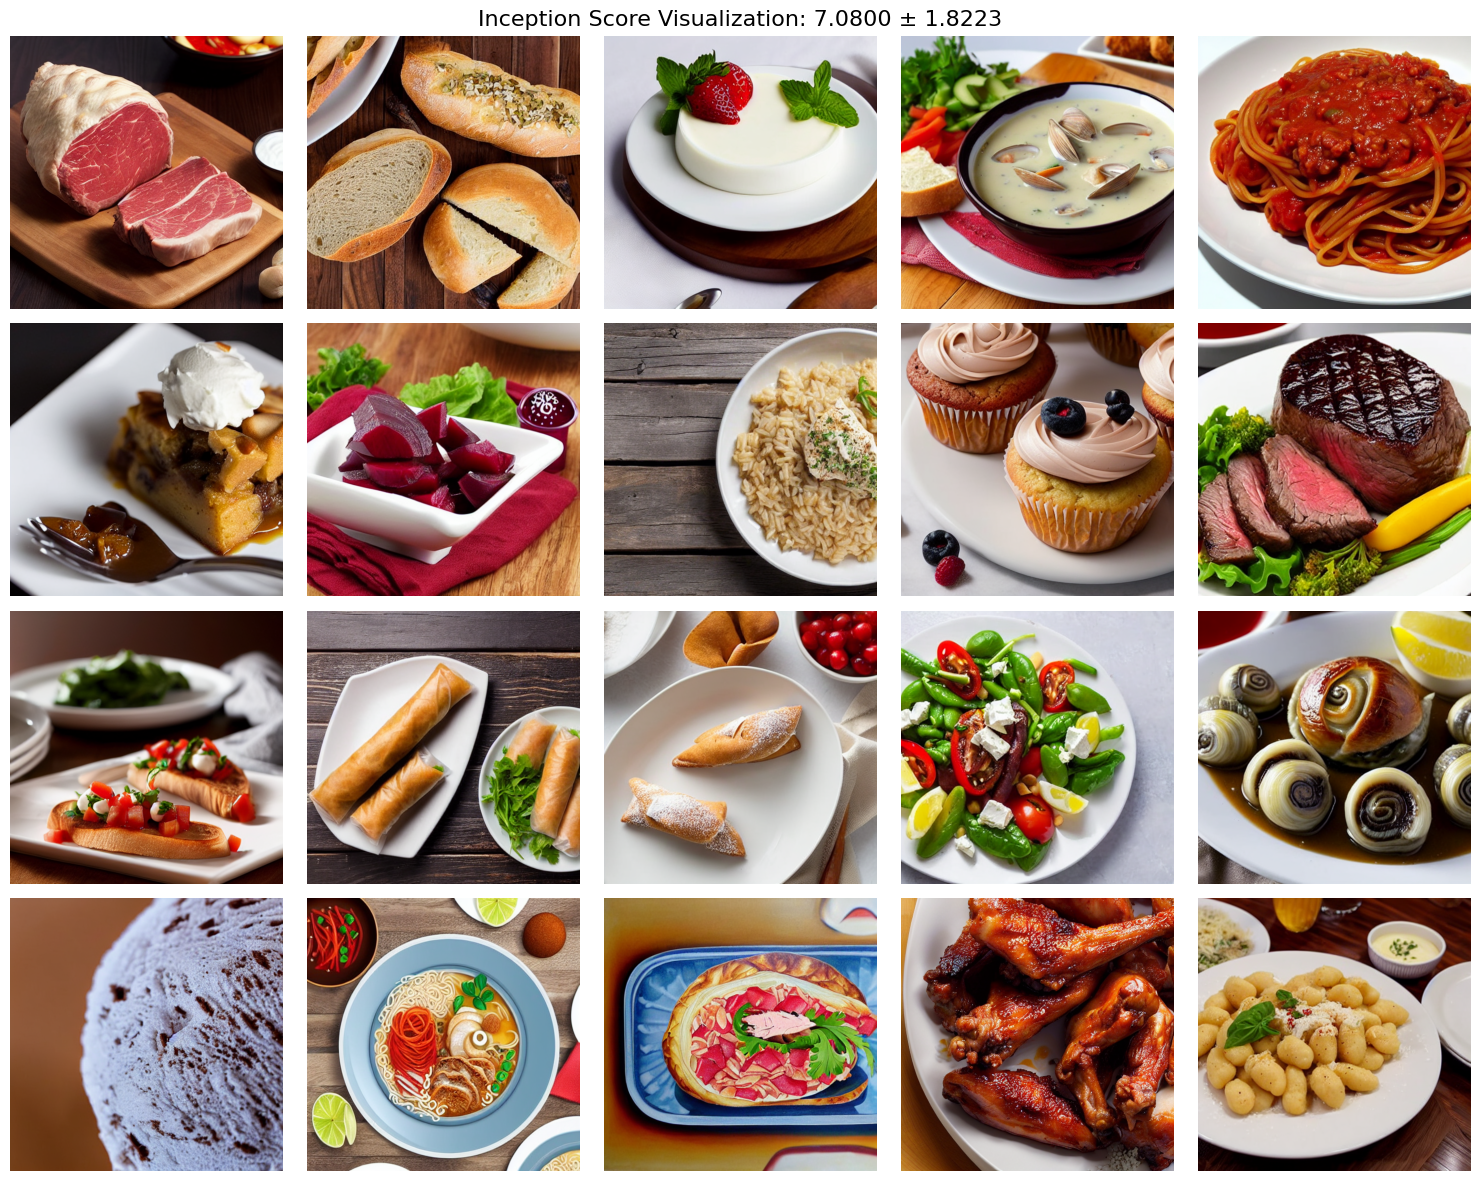

In [ ]:
def main():

    # Create directories
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    os.makedirs(GENERATED_DIR, exist_ok=True)

    # Fine-tuning
    pipe, unet, text_encoder = fine_tune_stable_diffusion()
    pipe.save_pretrained(f"{OUTPUT_DIR}/full_pipeline")

    # Save checkpoint with timestamp
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    checkpoint_path = f"{OUTPUT_DIR}/food101_sd_checkpoint_{timestamp}.pt"

    # Combined checkpoint
    checkpoint = {
        'unet_lora': unet.state_dict(),
        'text_encoder_lora': text_encoder.state_dict(),
        'timestamp': timestamp,
        'model_id': "runwayml/stable-diffusion-v1-5",  # Base model info
        'description': "Food101 fine-tuned Stable Diffusion with LoRA"
    }

    # Save combined checkpoint
    torch.save(checkpoint, checkpoint_path)
    print(f"Saved combined checkpoint to {checkpoint_path}")

    print("Fine-tuning and evaluation complete!")

main()